# Gradient-Boosting Classifier

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBClassifier

## Merge additional features (wards & districts) to the dataset

In [2]:
import requests, json
r = requests.get('https://data.cityofchicago.org/resource/crimes.json?$limit=600000')
data = r.json()
sec_df = pd.DataFrame(data)
sec_df = sec_df[['case_number','ward','district']]

In [3]:
original_data = pd.read_csv('Arrests_cleaned.csv')
location_data = sec_df.dropna()
merged_df = pd.merge(original_data, location_data, 'inner', left_on='CASE NUMBER', right_on='case_number')

print("size of the dataset: ", len(merged_df))
merged_df.columns

size of the dataset:  68408


Index(['ACB_NO', 'CASE NUMBER', 'ARREST MONTH', 'ARREST DATE', 'ARREST YEAR',
       'ARREST TIME', 'ARREST MERIDIEM', 'RACE', 'CHARGE 1 STATUTE',
       'CHARGE 1 DESCRIPTION', 'CHARGE 1 TYPE', 'CHARGE 1 CLASS',
       'CHARGE 2 STATUTE', 'CHARGE 2 DESCRIPTION', 'CHARGE 2 TYPE',
       'CHARGE 2 CLASS', 'CHARGE 3 STATUTE', 'CHARGE 3 DESCRIPTION',
       'CHARGE 3 TYPE', 'CHARGE 3 CLASS', 'CHARGE 4 STATUTE',
       'CHARGE 4 DESCRIPTION', 'CHARGE 4 TYPE', 'CHARGE 4 CLASS',
       'CHARGES STATUTE', 'CHARGES DESCRIPTION', 'CHARGES TYPE',
       'CHARGES CLASS', 'case_number', 'ward', 'district'],
      dtype='object')

In [4]:
df = merged_df
df

,ACB_NO,CASE NUMBER,ARREST MONTH,ARREST DATE,ARREST YEAR,ARREST TIME,ARREST MERIDIEM,RACE,CHARGE 1 STATUTE,CHARGE 1 DESCRIPTION,...,CHARGE 4 DESCRIPTION,CHARGE 4 TYPE,CHARGE 4 CLASS,CHARGES STATUTE,CHARGES DESCRIPTION,CHARGES TYPE,CHARGES CLASS,case_number,ward,district
0,30039812,JE183770,3,30,2021,12:10:00,AM,WHITE HISPANIC,720 ILCS 5.0/12-3.2-A-1,DOMESTIC BATTERY - BODILY HARM,...,NaN,NaN,NaN,720 ILCS 5.0/12-3.2-A-1 | | |,DOMESTIC BATTERY - BODILY HARM | | |,M | | |,A | | |,JE183770,14,008
1,30063075,JE276251,6,23,2021,12:04:00,AM,BLACK,720 ILCS 5.0/12-3.2-A-2,DOMESTIC BATTERY - PHYSICAL CONTACT,...,NaN,NaN,NaN,720 ILCS 5.0/12-3.2-A-2 | 720 ILCS 5.0/21-1-A-...,DOMESTIC BATTERY - PHYSICAL CONTACT | CRIM DAM...,M | M | |,A | A | |,JE276251,22,010
2,30069116,JE252804,7,16,2021,09:36:00,PM,BLACK,720 ILCS 5.0/12-3.3-A,DOMESTIC BATTERY - AGGRAVATED,...,NaN,NaN,NaN,720 ILCS 5.0/12-3.3-A | | |,DOMESTIC BATTERY - AGGRAVATED | | |,F | | |,2 | | |,JE252804,7,004
3,30069020,JE303350,7,16,2021,12:19:00,PM,BLACK,720 ILCS 5.0/24-1.6-A-1,AGG UUW/VEH/FIR LOADED/NO FOID,...,DRIVER'S LICENSE/PERMIT - FAIL TO CARRY/DISPLAY,NaN,P,720 ILCS 5.0/24-1.6-A-1 | 625 ILCS 5.0/11-708-...,AGG UUW/VEH/FIR LOADED/NO FOID | WRONG WAY ON ...,F | | |,4 | P | P | P,JE303350,24,011
4,30068977,JE303006,7,16,2021,04:24:00,AM,BLACK HISPANIC,720 ILCS 5.0/12-1-A,ASSAULT - SIMPLE,...,NaN,NaN,NaN,720 ILCS 5.0/12-1-A | | |,ASSAULT - SIMPLE | | |,M | | |,C | | |,JE303006,13,008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68403,30183808,JF425991,10,7,2022,06:20:00,PM,BLACK HISPANIC,720 ILCS 5.0/24-1.6-A-2,AGG UUW/PERS/UNLOADED/NO FCCA,...,NaN,NaN,NaN,720 ILCS 5.0/24-1.6-A-2 | 9-76-220(A) | |,AGG UUW/PERS/UNLOADED/NO FCCA | OBSTRUCTION DR...,F | | |,4 | L | |,JF425991,22,010
68404,30183795,JF425939,10,7,2022,05:40:00,PM,BLACK,720 ILCS 5.0/12-3.2-A-1,DOMESTIC BATTERY/BODILY HARM,...,NaN,NaN,NaN,720 ILCS 5.0/12-3.2-A-1 | | |,DOMESTIC BATTERY/BODILY HARM | | |,M | | |,A | | |,JF425939,34,022
68405,30183860,JF426166,10,7,2022,09:35:00,PM,BLACK,720 ILCS 5.0/24-1.6-A-1,AGG UUW/VEHICLE/LOADED/NO FCCA,...,HEADLIGHT TWO REQUIRED-MOTOR VEHICLE,NaN,L,720 ILCS 5.0/24-1.6-A-1 | 625 ILCS 5.0/6-303-A...,AGG UUW/VEHICLE/LOADED/NO FCCA | DRIVING ON SU...,F | M | M |,4 | A | A | L,JF426166,9,005
68406,30183842,JF426400,10,7,2022,07:16:00,PM,WHITE HISPANIC,720 ILCS 5.0/24-1.6-A-1,AGG UUW/VEHICLE/NO FOID,...,DL EXPIRED MORE THAN A YEAR,M,B,720 ILCS 5.0/24-1.6-A-1 | 720 ILCS 570.0/402-C...,AGG UUW/VEHICLE/NO FOID | PCS - POSSESSION - P...,F | F | M | M,4 | 4 | A | B,JF426400,7,003


## Data Preprocessing

In [5]:
races = df.loc[:, "RACE"].unique()
c1_types = df.loc[:, "CHARGE 1 TYPE"].unique()
print("races: ", races)
print("charge 1 type: ", c1_types)

races:  ['WHITE HISPANIC' 'BLACK' 'BLACK HISPANIC' 'WHITE'
 'ASIAN / PACIFIC ISLANDER' 'AMER INDIAN / ALASKAN NATIVE'
 'UNKNOWN / REFUSED']
charge 1 type:  ['M' 'F' 'O' 'R' 'V']


In [6]:
race_dummies = pd.get_dummies(df, columns=["RACE"])
dummy_races = ['RACE_AMER INDIAN / ALASKAN NATIVE', \
               'RACE_ASIAN / PACIFIC ISLANDER', 'RACE_BLACK', 'RACE_BLACK HISPANIC', \
               'RACE_UNKNOWN / REFUSED', 'RACE_WHITE', 'RACE_WHITE HISPANIC']
race_dummies = race_dummies[dummy_races]
race_dummies

,RACE_AMER INDIAN / ALASKAN NATIVE,RACE_ASIAN / PACIFIC ISLANDER,RACE_BLACK,RACE_BLACK HISPANIC,RACE_UNKNOWN / REFUSED,RACE_WHITE,RACE_WHITE HISPANIC
0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
68403,0,0,0,1,0,0,0
68404,0,0,1,0,0,0,0
68405,0,0,1,0,0,0,0
68406,0,0,0,0,0,0,1


In [7]:
month_dummies = pd.get_dummies(df, columns=["ARREST MONTH"])
dummy_month = ['ARREST MONTH_1', 'ARREST MONTH_2', 'ARREST MONTH_3', 'ARREST MONTH_4', \
       'ARREST MONTH_5', 'ARREST MONTH_6', 'ARREST MONTH_7', 'ARREST MONTH_8', \
       'ARREST MONTH_9', 'ARREST MONTH_10', 'ARREST MONTH_11', 'ARREST MONTH_12']
month_dummies = month_dummies[dummy_month]
month_dummies

,ARREST MONTH_1,ARREST MONTH_2,ARREST MONTH_3,ARREST MONTH_4,ARREST MONTH_5,ARREST MONTH_6,ARREST MONTH_7,ARREST MONTH_8,ARREST MONTH_9,ARREST MONTH_10,ARREST MONTH_11,ARREST MONTH_12
0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
68403,0,0,0,0,0,0,0,0,0,1,0,0
68404,0,0,0,0,0,0,0,0,0,1,0,0
68405,0,0,0,0,0,0,0,0,0,1,0,0
68406,0,0,0,0,0,0,0,0,0,1,0,0


In [8]:
districts = df.loc[:, "district"].unique().tolist()
districts_dummies = pd.get_dummies(df, columns=["district"])
districts = ["district_"+d for d in districts]
districts_dummies = districts_dummies[districts]
districts_dummies

,district_008,district_010,district_004,district_011,district_001,district_012,district_024,district_016,district_025,district_003,...,district_002,district_006,district_014,district_009,district_007,district_005,district_018,district_017,district_020,district_031
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68403,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
68406,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
wards = df.loc[:, "ward"].unique().tolist()
wards_dummies = pd.get_dummies(df, columns=["ward"])
wards = ["ward_"+w for w in wards]
wards_dummies = wards_dummies[wards]
wards_dummies

,ward_14,ward_22,ward_7,ward_24,ward_13,ward_42,ward_11,ward_48,ward_23,ward_41,...,ward_39,ward_38,ward_46,ward_40,ward_31,ward_35,ward_33,ward_18,ward_1,ward_30
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68403,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68406,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
month_num = df.loc[:, "ARREST MONTH"].astype(int)
month_num

0         3
1         6
2         7
3         7
4         7
         ..
68403    10
68404    10
68405    10
68406    10
68407    10
Name: ARREST MONTH, Length: 68408, dtype: int64

In [20]:
year_num = df.loc[:, "ARREST YEAR"].astype(int)
year_num.value_counts()

2020    25827
2021    23128
2022    19447
2019        3
2016        2
2014        1
Name: ARREST YEAR, dtype: int64

In [11]:
district_num = df.loc[:, "district"].astype(int) 
district_num

0         8
1        10
2         4
3        11
4         8
         ..
68403    10
68404    22
68405     5
68406     3
68407    11
Name: district, Length: 68408, dtype: int64

In [12]:
ward_num = df.loc[:, "ward"].astype(int) 
ward_num

0        14
1        22
2         7
3        24
4        13
         ..
68403    22
68404    34
68405     9
68406     7
68407    28
Name: ward, Length: 68408, dtype: int64

In [13]:
arrest_case_num = df.loc[:, "case_number"].str[2:].astype(int)
arrest_case_num

0        183770
1        276251
2        252804
3        303350
4        303006
          ...  
68403    425991
68404    425939
68405    426166
68406    426400
68407    426207
Name: case_number, Length: 68408, dtype: int64

In [14]:
arrest_ampm = df.loc[:, "ARREST MERIDIEM"].apply(lambda x: 1 if x == "AM" else 0)
arrest_ampm.value_counts()

0    44821
1    23587
Name: ARREST MERIDIEM, dtype: int64

In [15]:
arrest_time = df.loc[:, "ARREST TIME"].str[:2].astype(int)
arrest_time

0        12
1        12
2         9
3        12
4         4
         ..
68403     6
68404     5
68405     9
68406     7
68407    10
Name: ARREST TIME, Length: 68408, dtype: int64

In [16]:
arrest_date = df.loc[:, "ARREST DATE"].astype(int)
arrest_date

0        30
1        23
2        16
3        16
4        16
         ..
68403     7
68404     7
68405     7
68406     7
68407     7
Name: ARREST DATE, Length: 68408, dtype: int64

### Multi-Class Charge Types: Misdemeanor, Felony & Others

In [18]:
# three charge types
m_charge_types = df.loc[:, "CHARGE 1 TYPE"].replace('A', 'M')
m_charge_types = m_charge_types.replace('R', 'O')
m_charge_types = m_charge_types.replace('V', 'O')
multi_class_types = pd.factorize(m_charge_types)
multi_class_types = multi_class_types[0]
m_charge_types.value_counts()

M    34785
F    30469
O     3154
Name: CHARGE 1 TYPE, dtype: int64

#### Merge Columns

In [153]:
data = pd.concat([arrest_case_num, arrest_time, year_num, month_num, ward_num, district_num, arrest_ampm, race_dummies], axis=1)
print(data.columns)
data

Index(['case_number', 'ARREST TIME', 'ARREST YEAR', 'ARREST MONTH', 'ward',
       'district', 'ARREST MERIDIEM', 'RACE_AMER INDIAN / ALASKAN NATIVE',
       'RACE_ASIAN / PACIFIC ISLANDER', 'RACE_BLACK', 'RACE_BLACK HISPANIC',
       'RACE_UNKNOWN / REFUSED', 'RACE_WHITE', 'RACE_WHITE HISPANIC'],
      dtype='object')


,case_number,ARREST TIME,ARREST YEAR,ARREST MONTH,ward,district,ARREST MERIDIEM,RACE_AMER INDIAN / ALASKAN NATIVE,RACE_ASIAN / PACIFIC ISLANDER,RACE_BLACK,RACE_BLACK HISPANIC,RACE_UNKNOWN / REFUSED,RACE_WHITE,RACE_WHITE HISPANIC
0,183770,12,2021,3,14,8,1,0,0,0,0,0,0,1
1,276251,12,2021,6,22,10,1,0,0,1,0,0,0,0
2,252804,9,2021,7,7,4,0,0,0,1,0,0,0,0
3,303350,12,2021,7,24,11,0,0,0,1,0,0,0,0
4,303006,4,2021,7,13,8,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68403,425991,6,2022,10,22,10,0,0,0,0,1,0,0,0
68404,425939,5,2022,10,34,22,0,0,0,1,0,0,0,0
68405,426166,9,2022,10,9,5,0,0,0,1,0,0,0,0
68406,426400,7,2022,10,7,3,0,0,0,0,0,0,0,1


### Data Transformation (Scaling & Dimension Reduction)

In [154]:
# scaling
mm_scaler = MinMaxScaler()
sd_scaler = StandardScaler()
scaled_data = data.copy()
scaled_data.iloc[:, [0, 1, 2, 3]] = mm_scaler.fit_transform(scaled_data.iloc[:, [0, 1, 2, 3]])
scaled_data.iloc[:, [4, 5]] = sd_scaler.fit_transform(scaled_data.iloc[:, [4, 5]])
scaled_data

,case_number,ARREST TIME,ARREST YEAR,ARREST MONTH,ward,district,ARREST MERIDIEM,RACE_AMER INDIAN / ALASKAN NATIVE,RACE_ASIAN / PACIFIC ISLANDER,RACE_BLACK,RACE_BLACK HISPANIC,RACE_UNKNOWN / REFUSED,RACE_WHITE,RACE_WHITE HISPANIC
0,0.265539,1.000000,0.875,0.181818,-0.704951,-0.447300,1,0,0,0,0,0,0,1
1,0.402923,1.000000,0.875,0.454545,-0.091835,-0.149807,1,0,0,1,0,0,0,0
2,0.368091,0.727273,0.875,0.545455,-1.241426,-1.042284,0,0,0,1,0,0,0,0
3,0.443179,1.000000,0.875,0.545455,0.061443,-0.001061,0,0,0,1,0,0,0,0
4,0.442668,0.272727,0.875,0.545455,-0.781590,-0.447300,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68403,0.625366,0.454545,1.000,0.818182,-0.091835,-0.149807,0,0,0,0,1,0,0,0
68404,0.625289,0.363636,1.000,0.818182,0.827837,1.635147,0,0,0,1,0,0,0,0
68405,0.625626,0.727273,1.000,0.818182,-1.088147,-0.893538,0,0,0,1,0,0,0,0
68406,0.625974,0.545455,1.000,0.818182,-1.241426,-1.191030,0,0,0,0,0,0,0,1


In [174]:
# PCA
pca_project = PCA(n_components=10)
trans_data = pca_project.fit_transform(scaled_data)
trans_data.shape

(68408, 10)

### Train Testing Split

In [161]:
X_train, X_test, y_train_m, y_test_m = train_test_split(data, multi_class_types, test_size = 0.2)
print("train-test-sizes: ", len(X_train), len(X_test))

train-test-sizes:  54726 13682


In [162]:
X_train_s, X_test_s, y_train_m_s, y_test_m_s = train_test_split(scaled_data, multi_class_types, test_size = 0.2)
print("train-test-sizes: ", len(X_train_s), len(X_test_s))

train-test-sizes:  54726 13682


In [175]:
X_train_sp, X_test_sp, y_train_m_sp, y_test_m_sp = train_test_split(trans_data, multi_class_types, test_size = 0.2)
print("train-test-sizes: ", len(X_train_sp), len(X_test_sp))

train-test-sizes:  54726 13682


## XGBoost

### No Scaling and Dimension Reduction

In [164]:
# training
xgb_clf_m = XGBClassifier()
xgb_clf_m.fit(X_train, y_train_m)

# testing
score_m = xgb_clf_m.score(X_test, y_test_m)
print("accuracy score: ", score_m)

accuracy score:  0.6358719485455343


### Scaled Data

In [165]:
# training
xgb_clf_m_s = XGBClassifier()
xgb_clf_m_s.fit(X_train_s, y_train_m_s)

# testing
score_m_s = xgb_clf_m_s.score(X_test_s, y_test_m_s)
print("accuracy score: ", score_m_s)

accuracy score:  0.6341909077620231


### Scaled and Dimension-reduced Data

In [176]:
# training
xgb_clf_m_sp = XGBClassifier()
xgb_clf_m_sp.fit(X_train_sp, y_train_m_sp)

# testing
score_m_sp = xgb_clf_m_sp.score(X_test_sp, y_test_m_sp)
print("accuracy score: ", score_m_sp)

accuracy score:  0.6227890659260342


## LightGBM

In [167]:
# training
light_clf = HistGradientBoostingClassifier()
light_clf.fit(X_train, y_train_m)

# testing
score_light = light_clf.score(X_test, y_test_m)
print("accuracy score: ", score_light)

accuracy score:  0.633021488086537


In [168]:
# training
light_clf_s = HistGradientBoostingClassifier()
light_clf_s.fit(X_train_s, y_train_m_s)

# testing
score_light_s = light_clf_s.score(X_test_s, y_test_m_s)
print("accuracy score: ", score_light_s)

accuracy score:  0.6374068118696097


In [179]:
# training
light_clf_sp = HistGradientBoostingClassifier()
light_clf_sp.fit(X_train_sp, y_train_m_sp)

# testing
score_light_sp = light_clf_sp.score(X_test_sp, y_test_m_sp)
print("accuracy score: ", score_light_sp)

accuracy score:  0.6210349364128052


## Best Model (Cross-Validation)

In [183]:
hist_params = {"max_iter": [100, 150, 200], "max_leaf_nodes": [31, None], "max_depth": [9, None], "l2_regularization": [0, 0.001, 0.1]}
hist_clf = HistGradientBoostingClassifier()
hist_clf_cv = GridSearchCV(hist_clf, scoring='accuracy', cv=5, param_grid=hist_params)
hist_clf_cv.fit(X_train_s, y_train_m_s)
print("best accuracy: ", hist_clf_cv.best_score_)
print("best parameters: ", hist_clf_cv.best_params_)

best accuracy:  0.6300477755453346
best parameters:  {'l2_regularization': 0.001, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31}


In [184]:
hist_clf_cv.score(X_test_s, y_test_m_s)

0.6323636895190762

## Knee Method on PCA Dimensions

In [187]:
# Plot
dims = list(range(1, 14))
acc_scores = []
for dim in dims:
    # PCA
    pca_project = PCA(n_components=dim)
    trans_s_data = pca_project.fit_transform(X_train_s)

    # CV
    hist_params = {'l2_regularization': [0.001], 'max_depth': [None], 'max_iter': [100], 'max_leaf_nodes': [31]}
    hist_clf = HistGradientBoostingClassifier()
    hist_clf_cv = GridSearchCV(hist_clf, scoring='accuracy', cv=5, param_grid=hist_params)
    hist_clf_cv.fit(trans_s_data, y_train_m_s)
    acc_scores.append(hist_clf_cv.best_score_)
    print("dim = ", dim, " accuracy score: ", hist_clf_cv.best_score_)

dim =  1  accuracy score:  0.5850235246795243
dim =  2  accuracy score:  0.6042466422439924
dim =  3  accuracy score:  0.6086137863377983
dim =  4  accuracy score:  0.6131088861245584
dim =  5  accuracy score:  0.6134925946110134
dim =  6  accuracy score:  0.6146620366587184
dim =  7  accuracy score:  0.6134377733893126
dim =  8  accuracy score:  0.6161787910701123
dim =  9  accuracy score:  0.6191571598169909
dim =  10  accuracy score:  0.6207835166063361
dim =  11  accuracy score:  0.6216422460791574
dim =  12  accuracy score:  0.6251871887050153
dim =  13  accuracy score:  0.6248765779631509


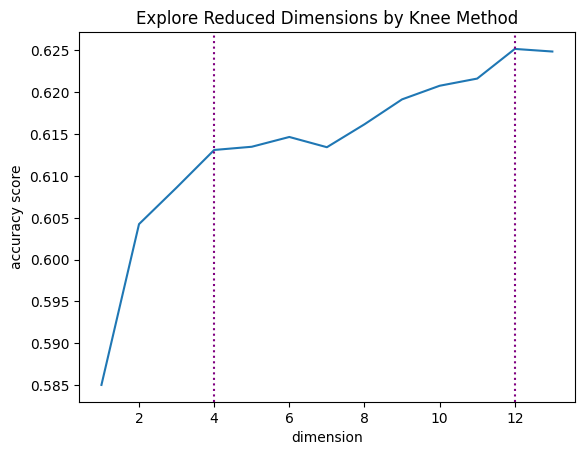

In [196]:
plt.plot(dims, acc_scores)
plt.axvline(x = 4, color = 'purple', label = 'axvline - full height', linestyle=":")
plt.axvline(x = 12, color = 'purple', label = 'axvline - full height', linestyle=":")
plt.xlabel("dimension")
plt.ylabel("accuracy score")
plt.title("Explore Reduced Dimensions by Knee Method")
plt.show()